In [1]:
import sys
sys.path.append("/home/leo/ExpStableDynamics/plos_comp_bio_rebuttal/Robust_WM_STSP/robust_wm_stsp")

%load_ext autoreload
%autoreload 2

In [2]:
from lightning_networks import dDMTSNet
from lightning_task import dDMTSDataModule
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import argparse
from pytorch_lightning import Trainer
from pytorch_lightning.plugins import DDPPlugin
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
from lightning_helper import distance_between_rnn_distracted_and_undistracted,distance_between_rnn_samples,get_validation_accuracy,do_info_over_trials,decoder,rnn_norm_of_response
import numpy as np
from PIL import Image     
from copy import deepcopy
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


lightning_networks.dDMTSNet

# Import Testers and Models

In [5]:
dt_ann = 15
#load data generator
dDMTS = dDMTSDataModule(dt_ann = dt_ann)  
dDMTS.setup()
tester = dDMTS.test_dataloader()

In [3]:
#load trained models
filepath = '/home/leo/ExpStableDynamics/plos_comp_bio_rebuttal/Robust_WM_STSP/scripts/_lightning_sandbox/checkpoints/'

#model_ah = dDMTSNet.load_from_checkpoint('/home/leo/ExpStableDynamics/DMTSANN/_lightning_sandbox/checkpoints/10-8-21/rnn-sample-dDMTS-epoch=64-val_acc=0.92--ah--none.ckpt')
#model_stsp = dDMTSNet.load_from_checkpoint('/home/leo/ExpStableDynamics/DMTSANN/_lightning_sandbox/checkpoints/10-8-21/rnn-sample-dDMTS-epoch=99-val_acc=0.90--stsp--relu.ckpt')
#model_tanh = dDMTSNet.load_from_checkpoint('/home/leo/ExpStableDynamics/DMTSANN/_lightning_sandbox/checkpoints/10-8-21/rnn-sample-dDMTS-epoch=09-val_acc=0.96--vRNN--tanh.ckpt')
#model_relu = dDMTSNet.load_from_checkpoint('/home/leo/ExpStableDynamics/DMTSANN/_lightning_sandbox/checkpoints/10-8-21/rnn-sample-dDMTS-epoch=10-val_acc=0.96--vRNN--relu.ckpt')

#model_ah_fast_w = dDMTSNet.load_from_checkpoint('/home/leo/ExpStableDynamics/DMTSANN/_lightning_sandbox/_lightning_sandbox/checkpoints/rnn-sample-dDMTS-epoch=86-val_acc=0.95--ah--none.ckpt')


#model_tanh = dDMTSNet.load_from_checkpoint(filepath + 'last_rnn-sample-dDMTS-epoch=02-val_acc=1.00--vRNN--tanh.ckpt')
#model_relu = dDMTSNet.load_from_checkpoint(filepath + 'last_rnn-sample-dDMTS-epoch=03-val_acc=0.99--vRNN--relu.ckpt')
#model_stsp = dDMTSNet.load_from_checkpoint(filepath + 'last_rnn-sample-dDMTS-epoch=03-val_acc=0.96--stsp--relu.ckpt')
model_ah = dDMTSNet.load_from_checkpoint(filepath + 'last_rnn-sample-dDMTS-epoch=02-val_acc=0.94--ah--none.ckpt')

# Do Norm Analysis

In [176]:
with torch.no_grad():
    norms_neur_ah,norms_neur_distracted_ah,norms_syn_ah,norms_syn_distracted_ah = rnn_norm_of_response(model_ah,tester)
    norms_neur_stsp,norms_neur_distracted_stsp,norms_syn_stsp,norms_syn_distracted_stsp = rnn_norm_of_response(model_stsp,tester)
    norms_neur_tanh,norms_neur_distracted_tanh,norms_syn_tanh,norms_syn_distracted_tanh = rnn_norm_of_response(model_tanh,tester)
    norms_neur_relu,norms_neur_distracted_relu,norms_syn_relu,norms_syn_distracted_relu = rnn_norm_of_response(model_relu,tester)
    
    #inp, out_des,y,test_on,dis_bool = next(iter(tester))
    #out_readout, out_hidden,w_hidden,_= model_ah_fast_w(inp)

In [29]:
inp, out_des,y,test_on,dis_bool = next(iter(tester))
inp.shape


#out_readout, out_hidden,w_hidden,_= model_ah(inp)

torch.Size([1024, 434, 11])

Text(0.5, 1.0, 'ah')

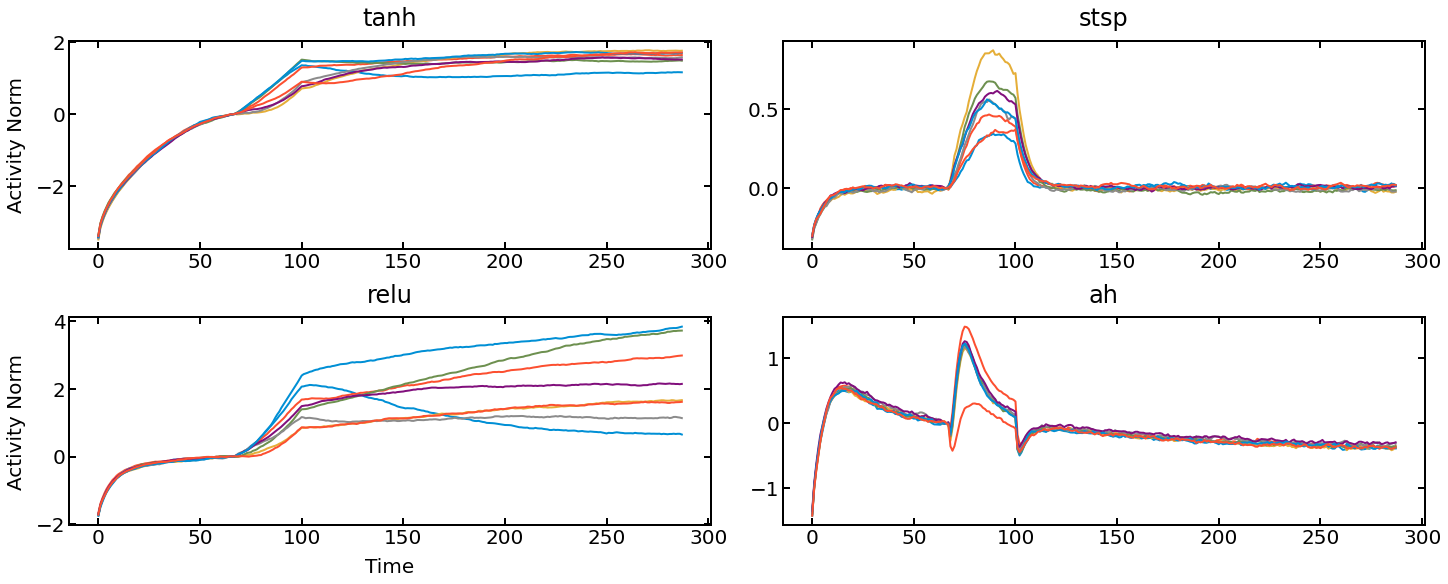

In [178]:
samp_on = int(1000/dt_ann)
unique_delay_times = torch.unique(test_on)
index_to_plot = 3

fig, axs = plt.subplot_mosaic([['a)', 'b)'],['c)','d)']], figsize = (20,8),constrained_layout=True)
lw = 5
fs = 40

def plot_norms_for_one_delay(ax,norms,delay = 3):
    for i in range(8):
        ax.plot(norms[delay][i][samp_on:int(unique_delay_times[index_to_plot])])

plot_norms_for_one_delay(axs['a)'],norms_neur_tanh,delay = 3)
plot_norms_for_one_delay(axs['c)'],norms_neur_relu,delay = 3)

plot_norms_for_one_delay(axs['b)'],norms_neur_stsp,delay = 3)
plot_norms_for_one_delay(axs['d)'],norms_neur_ah,delay = 3)


axs['a)'].set_title('tanh')
axs['a)'].set_ylabel('Activity Norm')

axs['b)'].set_title('stsp')
axs['c)'].set_title('relu')
axs['c)'].set_ylabel('Activity Norm')
axs['c)'].set_xlabel('Time')

axs['d)'].set_title('ah')



# Do Distance Analysis

In [8]:
#get distances
dist_neur_distract_tanh,dist_syn_distract_tanh = distance_between_rnn_distracted_and_undistracted(model_tanh,tester)
dist_neur_distract_relu,dist_syn_distract_relu = distance_between_rnn_distracted_and_undistracted(model_relu,tester)
dist_neur_distract_stsp,dist_syn_distract_stsp = distance_between_rnn_distracted_and_undistracted(model_stsp,tester)
dist_neur_distract_ah,dist_syn_distract_ah = distance_between_rnn_distracted_and_undistracted(model_ah,tester)


dist_neur_samp_tanh,dist_syn_samp_tanh = distance_between_rnn_samples(model_tanh,tester)
dist_neur_samp_relu,dist_syn_samp_relu = distance_between_rnn_samples(model_relu,tester)
dist_neur_samp_stsp,dist_syn_samp_stsp = distance_between_rnn_samples(model_stsp,tester)
dist_neur_samp_ah,dist_syn_samp_ah = distance_between_rnn_samples(model_ah,tester)


In [27]:
def repeat_distance(model,tester,num_repeats):
    '''
    Loops over distance analysis for specified number of times
    '''
    dists_distract_neur,dists_distract_syn = [], []
    dists_samp_neur,dists_samp_sym = [],[]
    for i in range(num_repeats):
        dist_neur_distract,dist_syn_distract = distance_between_rnn_distracted_and_undistracted(model,tester)
        dist_neur_samp,dist_syn_samp = distance_between_rnn_samples(model,tester)
        
        dists_distract_neur.append(dist_neur_distract)
        dists_distract_syn.append(dist_syn_distract)
        
        dists_samp_neur.append(dist_neur_samp)
        dists_samp_sym.append(dist_syn_samp)
    
    return dists_samp_neur,dists_samp_sym,dists_distract_neur,dists_distract_syn 

def extract_distances_for_delay(dists):
    num_time_points = len(dists[0][-1])
    num_repeats = len(dists)
    dists_over_repeats = np.zeros((num_repeats,num_time_points))
    for i in range(num_repeats):
        dists_over_repeats[i] = dists[i][-1]
        
    return dists_over_repeats
        
    
        
        

In [48]:
all_dists_samp_neur_tanh,all_dists_samp_sym_tanh,all_dists_distract_neur_tanh,all_dists_distract_syn_tanh = repeat_distance(model_ah,tester,10)

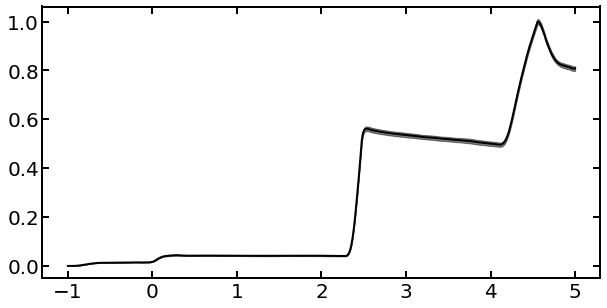

In [59]:
dists_over_repeats = extract_distances_for_delay(all_dists_distract_syn_tanh)
def get_mean_and_standard_error(arr):
    y_mean = arr.mean(0)
    y_std_err =arr.std(0)/np.sqrt(arr.shape[0])
    return y_mean, y_std_err

y_mean, y_std_err = get_mean_and_standard_error(dists_over_repeats)
time = np.linspace(-1,5,len(y_mean))
scale = y_mean.max()

plt.plot(time, y_mean/scale,color = 'k')
plt.fill_between(time, (y_mean-y_std_err)/scale, (y_mean+y_std_err)/scale, alpha=0.5,color = 'k')

In [47]:
i = 4
def add_dist_to_axis(fig,axes,axis_label,tvec,dist_neur,dists_neur_std_err,dist_syn,dists_syn_std_err,fixed_syn,title = '',xlabel = '',ylabel = '',legend = False,bbox_height = 0.61):
    axs[axis_label].axvspan(0,0.5,alpha = 0.2,color = samp_color,label = 'Sample')    
    axs[axis_label].axvspan(0.5+delays[i]/2,0.5+delays[i]/2+0.25,alpha = 0.2,color = dis_color,label = 'Distractor')
    axs[axis_label].axvspan(0.5+delays[i],1+delays[i],alpha = 0.2,color = test_color)
    axs[axis_label].set_title(title)
    if legend:
        fig.legend(['Sample','Distractor'],bbox_to_anchor=[0.5, bbox_height],loc='center', ncol=4)
    scale = 1e-6+dist_neur.max()
    axs[axis_label].plot(tvec,dist_neur/scale,'k',linewidth = lw)
    axs[axis_label].fill_between(tvec,(dist_neur-dists_neur_std_err)/scale,(dist_neur+dists_neur_std_err)/scale)
    if not fixed_syn:
        scale = 1e-6+dist_syn[i].max()
        axs[axis_label].plot(tvec,dist_syn/scale,color = 'm',linewidth = lw)
        axs[axis_label].fill_between(tvec,(dist_syn-dists_syn_std_err)/scale,(dist_syn+dists_syn_std_err)/scale)
    
    axs[axis_label].set_ylim([0,1.1])
    #axs[axis_label].set_xlim([-1,5.5])
    axs[axis_label].set_xlabel(xlabel)
    axs[axis_label].set_ylabel(ylabel)
    #axs['b)'].set_title('b)', fontfamily='DejaVu Sans', loc='left', fontsize=fs)
    
    
    if xlabel == '':
        axs[axis_label].get_xaxis().set_ticks([])
    if ylabel == '':
        axs[axis_label].get_yaxis().set_ticks([])
    
    
#plt.savefig('Figs/distances_FS.png',dpi = 300)    

(-0.5, 4.5)

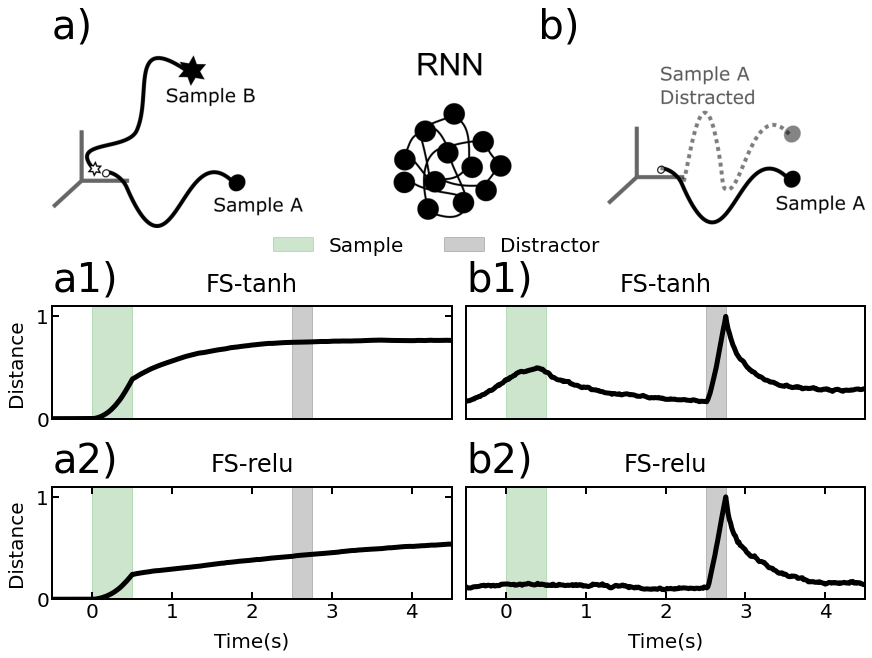

In [10]:
plt.style.use('sci_style.py')
#fig, axs = plt.subplots(1,2,figsize = (15,4),sharey = True)
i = 4
delays = [1.  , 1.41, 2.  , 2.83, 4.  ]
samp_color = 'g'
test_color = 'b'
dis_color = 'k'
lw = 5
fs = 40


tvec = np.linspace(-1,5.5,len(dist_neur_distract_tanh[i]))

fig, axs = plt.subplot_mosaic([['a)','a)'], ['b)', 'c)'],['d)', 'e)']],
                              constrained_layout=True,
                              figsize = (12,9),
                              gridspec_kw={"height_ratios": [1, 0.5, 0.5],
                                           "width_ratios": [1, 1]})
img = Image.open('Figs/Cartoon1.png')
axs['a)'].imshow(img)
axs['a)'].spines['top'].set_visible(False)
axs['a)'].spines['right'].set_visible(False)
axs['a)'].spines['bottom'].set_visible(False)
axs['a)'].spines['left'].set_visible(False)
axs['a)'].get_xaxis().set_ticks([])
axs['a)'].get_yaxis().set_ticks([])         
axs['a)'].set_title('a)                                   b)', fontfamily='DejaVu Sans', loc='left', fontsize=fs)


add_dist_to_axis(fig,axs,'b)',tvec,dist_neur_samp_tanh,dist_syn_samp_tanh,model_tanh.fixed_syn,'FS-tanh','','Distance',True,0.63)
axs['b)'].set_title('a1)', fontfamily='DejaVu Sans', loc='left', fontsize=fs)
axs['b)'].set_xlim([-0.5,4.5])

add_dist_to_axis(fig,axs,'d)',tvec,dist_neur_samp_relu,dist_syn_samp_relu,model_relu.fixed_syn,'FS-relu','Time(s)','Distance',False)
axs['c)'].set_title('b1)', fontfamily='DejaVu Sans', loc='left', fontsize=fs)
axs['c)'].set_xlim([-0.5,4.5])

add_dist_to_axis(fig,axs,'c)',tvec,dist_neur_distract_tanh,dist_syn_distract_tanh,model_tanh.fixed_syn,'FS-tanh','','',False)
axs['d)'].set_title('a2)', fontfamily='DejaVu Sans', loc='left', fontsize=fs)
axs['d)'].set_xlim([-0.5,4.5])

add_dist_to_axis(fig,axs,'e)',tvec,dist_neur_distract_relu,dist_syn_distract_relu,model_relu.fixed_syn,'FS-relu','Time(s)','',False)
axs['e)'].set_title('b2)', fontfamily='DejaVu Sans', loc='left', fontsize=fs)
axs['e)'].set_xlim([-0.5,4.5])


#plt.savefig('Figs/distances_FS.png',dpi = 300) 

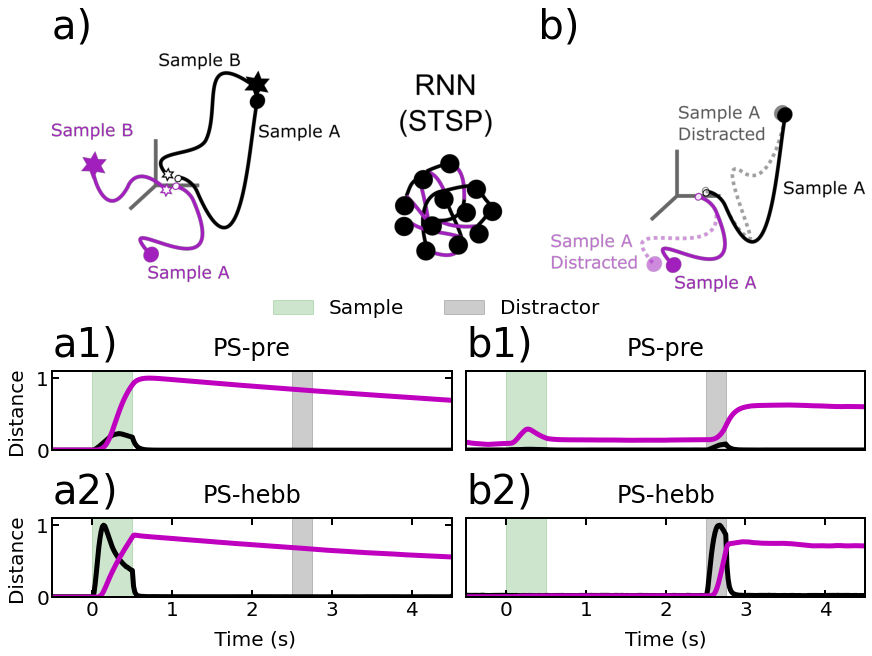

In [64]:
plt.style.use('sci_style.py')
#fig, axs = plt.subplots(1,2,figsize = (15,4),sharey = True)
i = 4
delays = [1.  , 1.41, 2.  , 2.83, 4.  ]
samp_color = 'g'
test_color = 'b'
dis_color = 'k'
lw = 5
fs = 40


tvec = np.linspace(-1,5.5,len(dist_neur_distract_tanh[i]))

fig, axs = plt.subplot_mosaic([['f)','f)'],['g)','h)'],['i)','j)']],
                              constrained_layout=True,
                              figsize = (12,9),
                              gridspec_kw={"height_ratios": [1.1, 0.3, 0.3],
                                           "width_ratios": [1, 1]})

img = Image.open('Figs/Cartoon2.png')
axs['f)'].imshow(img)
axs['f)'].spines['top'].set_visible(False)
axs['f)'].spines['right'].set_visible(False)
axs['f)'].spines['bottom'].set_visible(False)
axs['f)'].spines['left'].set_visible(False)
axs['f)'].get_xaxis().set_ticks([])
axs['f)'].get_yaxis().set_ticks([])
axs['f)'].set_title('a)                                   b)', fontfamily='DejaVu Sans', loc='left', fontsize=40)

add_dist_to_axis(fig,axs,'g)',tvec,dist_neur_samp_stsp,dist_syn_samp_stsp,model_stsp.fixed_syn,'PS-pre','','Distance',True,bbox_height = 0.53)
axs['g)'].set_title('a1)', fontfamily='DejaVu Sans', loc='left', fontsize=fs)
axs['g)'].set_xlim([-0.5,4.5])

add_dist_to_axis(fig,axs,'i)',tvec,dist_neur_samp_ah,dist_syn_samp_ah,model_ah.fixed_syn,'PS-hebb',' Time (s)','Distance',False)
axs['i)'].set_title('a2)', fontfamily='DejaVu Sans', loc='left', fontsize=fs)
axs['i)'].set_xlim([-0.5,4.5])

add_dist_to_axis(fig,axs,'h)',tvec,dist_neur_distract_stsp,dist_syn_distract_stsp,model_stsp.fixed_syn,'PS-pre','','',False)
axs['h)'].set_title('b1)', fontfamily='DejaVu Sans', loc='left', fontsize=fs)
axs['h)'].set_xlim([-0.5,4.5])

add_dist_to_axis(fig,axs,'j)',tvec,dist_neur_distract_ah,dist_syn_distract_ah,model_ah.fixed_syn,'PS-hebb','Time (s)','',False)
axs['j)'].set_title('b2)', fontfamily='DejaVu Sans', loc='left', fontsize=fs)
axs['j)'].set_xlim([-0.5,4.5])

plt.savefig('Figs/distances_PS.png',dpi = 300)    

# Do Information Analysis

In [5]:
#get information measures
#load trained model
info_neur_tanh,info_syn_tanh = decoder(model_tanh,tester)
info_neur_relu,info_syn_relu = decoder(model_relu,tester)
info_neur_stsp,info_syn_stsp = decoder(model_stsp,tester)
info_neur_ah,info_syn_ah = decoder(model_ah,tester)

In [6]:
i = 4
def add_info_to_axis(fig,axes,axis_label,tvec,info_neur,info_syn,fixed_syn,title = '',xlabel = '',ylabel = '',legend = False):
    axs[axis_label].axvspan(0,0.5,alpha = 0.2,color = samp_color,label = 'Sample')    
    axs[axis_label].axvspan(0.5+delays[i]/2,0.5+delays[i]/2+0.25,alpha = 0.2,color = dis_color,label = 'Distractor')
    axs[axis_label].axvspan(0.5+delays[i],1+delays[i],alpha = 0.2,color = test_color)
    axs[axis_label].set_title(title)
    axs[axis_label].hlines(1/8,-1,5.5,linewidth = lw,linestyle = '--',label = 'Chance Accuracy')
    if legend:
        fig.legend(bbox_to_anchor=[0.5, 0.65],loc='center', ncol=4)
   
    axs[axis_label].plot(tvec,info_neur[i]/(1e-6+info_neur[i].max()),'k',linewidth = lw)
    if not fixed_syn:
        axs[axis_label].plot(tvec,info_syn[i]/(1e-6+info_syn[i].max()),color = 'm',linewidth = lw)
    
    axs[axis_label].set_ylim([0,1.1])
    axs[axis_label].set_xlim([-1,5.5])
    axs[axis_label].set_xlabel(xlabel)
    axs[axis_label].set_ylabel(ylabel)
    #axs['b)'].set_title('b)', fontfamily='DejaVu Sans', loc='left', fontsize=fs)
    
    
    if xlabel == '':
        axs[axis_label].get_xaxis().set_ticks([])
    if ylabel == '':
        axs[axis_label].get_yaxis().set_ticks([])
    
    
    

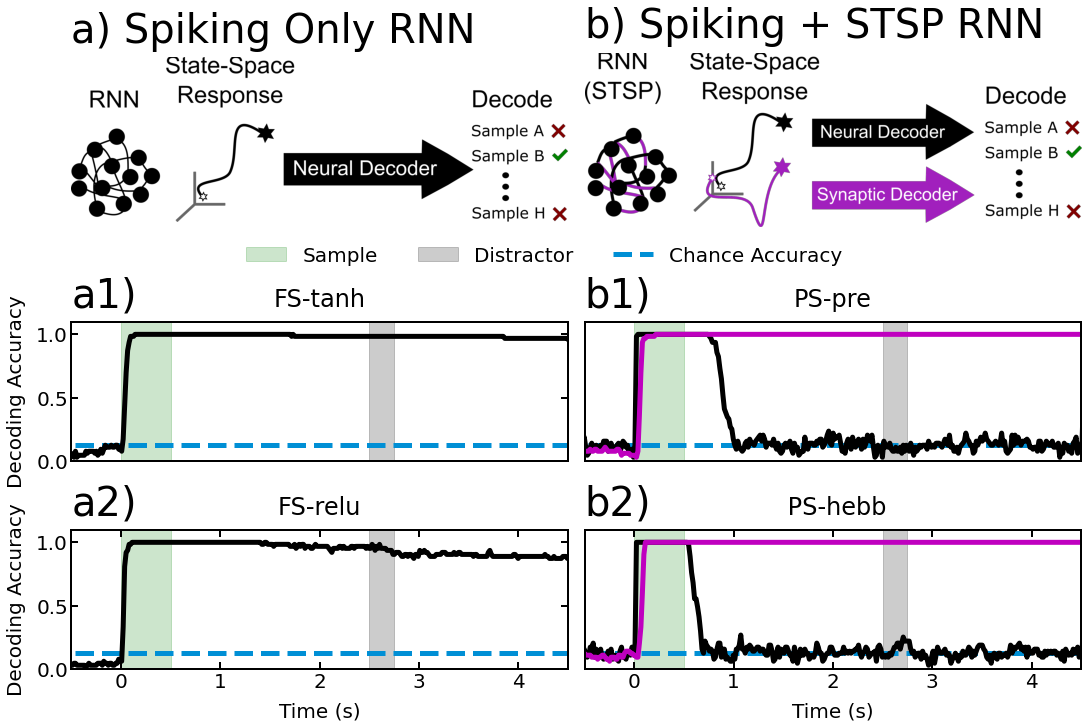

In [7]:
plt.style.use('sci_style.py')
#fig, axs = plt.subplots(1,2,figsize = (15,4),sharey = True)
i = 4
delays = [1.  , 1.41, 2.  , 2.83, 4.  ]
samp_color = 'g'
test_color = 'b'
dis_color = 'k'
lw = 5
fs = 40


tvec = np.linspace(-1,5.5,len(info_neur_tanh[i]))

fig, axs = plt.subplot_mosaic([['a)', 'b)'], ['c)', 'd)'],['e)', 'f)']],
                              constrained_layout=True,
                              figsize = (15,10),
                              gridspec_kw={"height_ratios": [1.1, .6, .6],
                                           "width_ratios": [1, 1]})
img = Image.open('Figs/infofig1.png')
axs['a)'].imshow(img)
axs['a)'].spines['top'].set_visible(False)
axs['a)'].spines['right'].set_visible(False)
axs['a)'].spines['bottom'].set_visible(False)
axs['a)'].spines['left'].set_visible(False)
axs['a)'].get_xaxis().set_ticks([])
axs['a)'].get_yaxis().set_ticks([])
axs['a)'].set_title('a) Spiking Only RNN', fontfamily='DejaVu Sans', loc='left', fontsize=fs)

img = Image.open('Figs/infofig2.png')
axs['b)'].imshow(img)
axs['b)'].spines['top'].set_visible(False)
axs['b)'].spines['right'].set_visible(False)
axs['b)'].spines['bottom'].set_visible(False)
axs['b)'].spines['left'].set_visible(False)
axs['b)'].get_xaxis().set_ticks([])
axs['b)'].get_yaxis().set_ticks([])
axs['b)'].set_title('b)', fontfamily='DejaVu Sans', loc='left', fontsize=fs)
axs['b)'].set_title('b) Spiking + STSP RNN', fontfamily='DejaVu Sans', loc='left', fontsize=fs)

add_info_to_axis(fig,axs,'c)',tvec,info_neur_tanh,info_syn_tanh,model_tanh.fixed_syn,'FS-tanh','','Decoding Accuracy',True)
axs['c)'].set_title('a1)', fontfamily='DejaVu Sans', loc='left', fontsize=fs)
axs['c)'].set_xlim([-0.5,4.5])
add_info_to_axis(fig,axs,'e)',tvec,info_neur_relu,info_syn_relu,model_relu.fixed_syn,'FS-relu','Time (s)','Decoding Accuracy')
axs['e)'].set_title('a2)', fontfamily='DejaVu Sans', loc='left', fontsize=fs)
axs['e)'].set_xlim([-0.5,4.5])
add_info_to_axis(fig, axs,'d)',tvec,info_neur_stsp,info_syn_stsp,model_stsp.fixed_syn, 'PS-pre')
axs['d)'].set_title('b1)', fontfamily='DejaVu Sans', loc='left', fontsize=fs)
axs['d)'].set_xlim([-0.5,4.5])
add_info_to_axis(fig,axs,'f)',tvec,info_neur_ah,info_syn_ah,model_ah.fixed_syn,' PS-hebb','Time (s)')
axs['f)'].set_title('b2)', fontfamily='DejaVu Sans', loc='left', fontsize=fs)
axs['f)'].set_xlim([-0.5,4.5])

plt.savefig('Figs/decoding.png',dpi = 300)

# Do PCA Analysis (Nothing Here At the Moment)

In [6]:
def add_3D_axis_to_mosaic(fig,axs):
    for key in axs:
        ss = axs[key].get_subplotspec()
        axs[key].remove()
        fig.add_subplot(ss, projection='3d')
    return fig,axs

In [108]:
def flatten_out_hidden(out_hidden,y):   

    batch_size,time_size,neur_size = out_hidden.shape[0],out_hidden.shape[1],out_hidden.shape[2]
    outs_flat = out_hidden.reshape(batch_size*time_size,neur_size).cpu().detach()
    y_flat = y.repeat_interleave(time_size).cpu().detach()

    return outs_flat,y_flat

def get_dim_reduced_plot(model,tester,technique = 'lda',hidden = 'w_hidden'):
    
    inp, out_des,y,test_on,dis_bool = next(iter(tester))

    out_readout, out_hidden,w_hidden,_= model(inp)

    if hidden == 'w_hidden':
        outs_flat,y_flat = flatten_out_hidden(w_hidden[:,:],y)
    else:
        outs_flat,y_flat = flatten_out_hidden(out_hidden[:,:],y)
    
    if technique == 'pca':
        pca  = PCA(3)
        reduce_out = pca.fit_transform(outs_flat)
    if technique == 'lda':
        lda = LinearDiscriminantAnalysis(n_components=3)
        reduce_out = lda.fit_transform(outs_flat,y_flat)
        
    
    return reduce_out, y_flat

def add_3D_axes_to_mosaic(fig,axs):
    for key in axs:
        ss = axs[key].get_subplotspec()
        axs[key].remove()
        fig.add_subplot(ss, projection='3d')
    return fig

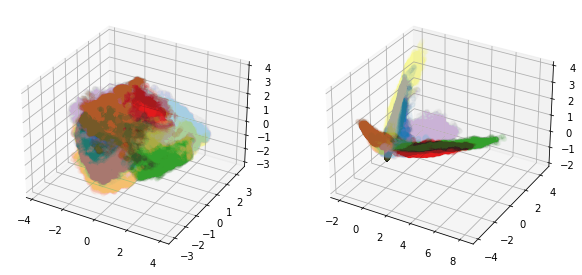

In [106]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#fig = plt.figure(figsize = (20,8))
#plt.rcParams.update({'font.size': 15})



fig = plt.figure(figsize=(10,5))
#axs = fig.subplot_mosaic([['a)', 'b)','c)'], ['d)', 'e)','f)']],)


axs['a)'] = fig.add_subplot(1, 2, 1, projection='3d')
axs['b)'] = fig.add_subplot(1, 2, 2, projection='3d')


reduce_out,y_flat = get_dim_reduced_plot(model_stsp,tester,technique = 'pca',hidden = 'n_hidden')
xline,yline,zline = reduce_out[:,0],reduce_out[:,1],reduce_out[:,2]
axs['a)'].scatter(xline, yline, zline,c = y_flat, cmap = plt.cm.get_cmap('Paired', 8),alpha  = .01)

reduce_out,y_flat = get_dim_reduced_plot(model_ah,tester,technique = 'pca',hidden = 'n_hidden')
xline,yline,zline = reduce_out[:,0],reduce_out[:,1],reduce_out[:,2]
axs['b)'].scatter(xline, yline, zline,c = y_flat, cmap = plt.cm.get_cmap('Paired', 8),alpha  = .01)


#fig.tight_layout()

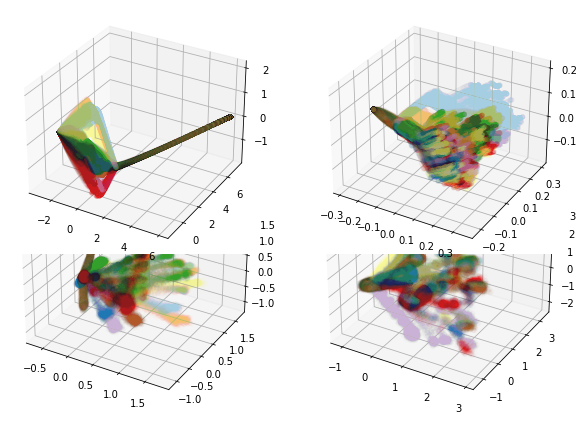

In [110]:
fig = plt.figure(figsize=(10,10))
#axs = fig.subplot_mosaic([['a)', 'b)','c)'], ['d)', 'e)','f)']],)


axs['a)'] = fig.add_subplot(1, 2, 1, projection='3d')
axs['b)'] = fig.add_subplot(1, 2, 2, projection='3d')
axs['c)'] = fig.add_subplot(2, 2, 1, projection='3d')
axs['d)'] = fig.add_subplot(2, 2, 2, projection='3d')

reduce_out,y_flat = get_dim_reduced_plot(model_stsp,tester,technique = 'pca',hidden = 'n_hidden')
xline,yline,zline = reduce_out[:,0],reduce_out[:,1],reduce_out[:,2]
axs['a)'].scatter(xline, yline, zline,c = y_flat, cmap = plt.cm.get_cmap('Paired', 8),alpha  = .01)

reduce_out,y_flat = get_dim_reduced_plot(model_ah,tester,technique = 'pca',hidden = 'n_hidden')
xline,yline,zline = reduce_out[:,0],reduce_out[:,1],reduce_out[:,2]
axs['b)'].scatter(xline, yline, zline,c = y_flat, cmap = plt.cm.get_cmap('Paired', 8),alpha  = .01)


reduce_out,y_flat = get_dim_reduced_plot(model_stsp,tester,technique = 'pca',hidden = 'w_hidden')
xline,yline,zline = reduce_out[:,0],reduce_out[:,1],reduce_out[:,2]
axs['c)'].scatter(xline, yline, zline,c = y_flat, cmap = plt.cm.get_cmap('Paired', 8),alpha  = .01)

reduce_out,y_flat = get_dim_reduced_plot(model_ah,tester,technique = 'pca',hidden = 'w_hidden')
xline,yline,zline = reduce_out[:,0],reduce_out[:,1],reduce_out[:,2]
axs['d)'].scatter(xline, yline, zline,c = y_flat, cmap = plt.cm.get_cmap('Paired', 8),alpha  = .01)

# Do Robustness Analysis

In [70]:
num_repeats = 10
num_noise_levels = 50

accs_ah_repeated = []
accs_stsp_repeated = []
accs_tanh_repeated = []
accs_relu_repeated = []

for i in range(num_repeats):
    print(i)
    structural_noise_levels = np.linspace(0,0.95,num_noise_levels)
    accs_ah = []
    accs_stsp = []
    accs_tanh = []
    accs_relu = []
    model = deepcopy(model_ah)
    for p in tqdm(structural_noise_levels):
        #import fresh copy
        pert_ah = deepcopy(model_ah)
        pert_stsp = deepcopy(model_stsp)
        pert_tanh = deepcopy(model_tanh)
        pert_relu = deepcopy(model_relu)

        random_mask = torch.FloatTensor(model.rnn.hidden_size, model.rnn.hidden_size).uniform_() > p

        with torch.no_grad():
            pert_ah.rnn.struc_perturb_mask = torch.FloatTensor(model.rnn.hidden_size, model.rnn.hidden_size).uniform_() > p
            pert_stsp.rnn.struc_perturb_mask = torch.FloatTensor(model.rnn.hidden_size, model.rnn.hidden_size).uniform_() > p
            pert_tanh.rnn.struc_perturb_mask = torch.FloatTensor(model.rnn.hidden_size, model.rnn.hidden_size).uniform_() > p
            pert_relu.rnn.struc_perturb_mask = torch.FloatTensor(model.rnn.hidden_size, model.rnn.hidden_size).uniform_() > p

            acc_ah = get_validation_accuracy(pert_ah,tester)
            acc_stsp = get_validation_accuracy(pert_stsp,tester)
            acc_tanh = get_validation_accuracy(pert_tanh,tester)
            acc_relu = get_validation_accuracy(pert_relu,tester)

        accs_ah.append(acc_ah)
        accs_stsp.append(acc_stsp)
        accs_tanh.append(acc_tanh)
        accs_relu.append(acc_relu)
    accs_ah_repeated.append(accs_ah)
    accs_stsp_repeated.append(accs_stsp)
    accs_tanh_repeated.append(accs_tanh)
    accs_relu_repeated.append(accs_relu)

accs_ah_repeated = np.stack(accs_ah_repeated)
accs_stsp_repeated = np.stack(accs_stsp_repeated)
accs_tanh_repeated = np.stack(accs_tanh_repeated)
accs_relu_repeated = np.stack(accs_relu_repeated)
    

  0%|          | 0/50 [00:00<?, ?it/s]

0


  0%|          | 0/50 [00:00<?, ?it/s]

1


  0%|          | 0/50 [00:00<?, ?it/s]

2


  0%|          | 0/50 [00:00<?, ?it/s]

3


  0%|          | 0/50 [00:00<?, ?it/s]

4


  0%|          | 0/50 [00:00<?, ?it/s]

5


  0%|          | 0/50 [00:00<?, ?it/s]

6


  0%|          | 0/50 [00:00<?, ?it/s]

7


  0%|          | 0/50 [00:00<?, ?it/s]

8


  0%|          | 0/50 [00:00<?, ?it/s]

9


100%|██████████| 50/50 [09:35<00:00, 11.50s/it]


In [79]:
accs_all = {'accs_ah_repeated':accs_ah_repeated,
           'accs_stsp_repeated':accs_stsp_repeated,
           'accs_tanh_repeated':accs_tanh_repeated,
           'accs_relu_repeated':accs_relu_repeated}

accs_all_noise = {'accs_ah_input_repeated':accs_ah_repeated,
           'accs_stsp_input_repeated':accs_stsp_repeated,
           'accs_tanh_input_repeated':accs_tanh_repeated,
           'accs_relu_input_repeated':accs_relu_repeated}

In [80]:
'''
try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle

with open('input_robust_data.p', 'wb') as fp:
    pickle.dump(accs_all_noise, fp, protocol=pickle.HIGHEST_PROTOCOL)
'''

# Do Input Noise Robustness Test

In [78]:
accs_ah_input_repeated = []
accs_stsp_input_repeated = []
accs_tanh_input_repeated = []
accs_relu_input_repeated = []

for i in range(num_repeats):
    input_noise_levels = np.linspace(0.05,0.95,num_noise_levels)
    accs_ah_input = []
    accs_stsp_input = []
    accs_tanh_input = []
    accs_relu_input = []

    for p in tqdm(input_noise_levels):
        #import fresh copy
        pert_ah = deepcopy(model_ah)
        pert_stsp = deepcopy(model_stsp)
        pert_tanh = deepcopy(model_tanh)
        pert_relu = deepcopy(model_relu)


        with torch.no_grad():
            pert_ah.rnn.process_noise = p
            pert_stsp.rnn.process_noise = p
            pert_tanh.rnn.process_noise = p
            pert_relu.rnn.process_noise = p

            acc_ah = get_validation_accuracy(pert_ah,tester)
            acc_stsp = get_validation_accuracy(pert_stsp,tester)
            acc_tanh = get_validation_accuracy(pert_tanh,tester)
            acc_relu = get_validation_accuracy(pert_relu,tester)

        accs_ah_input.append(acc_ah)
        accs_stsp_input.append(acc_stsp)
        accs_tanh_input.append(acc_tanh)
        accs_relu_input.append(acc_relu)

    accs_ah_input_repeated.append(accs_ah_input)
    accs_stsp_input_repeated.append(accs_stsp_input)
    accs_tanh_input_repeated.append(accs_tanh_input)
    accs_relu_input_repeated.append(accs_relu_input)

accs_ah_input_repeated = np.stack(accs_ah_input_repeated)
accs_stsp_input_repeated = np.stack(accs_stsp_input_repeated)
accs_tanh_input_repeated = np.stack(accs_tanh_input_repeated)
accs_relu_input_repeated = np.stack(accs_relu_input_repeated)

100%|██████████| 50/50 [10:03<00:00, 12.07s/it]


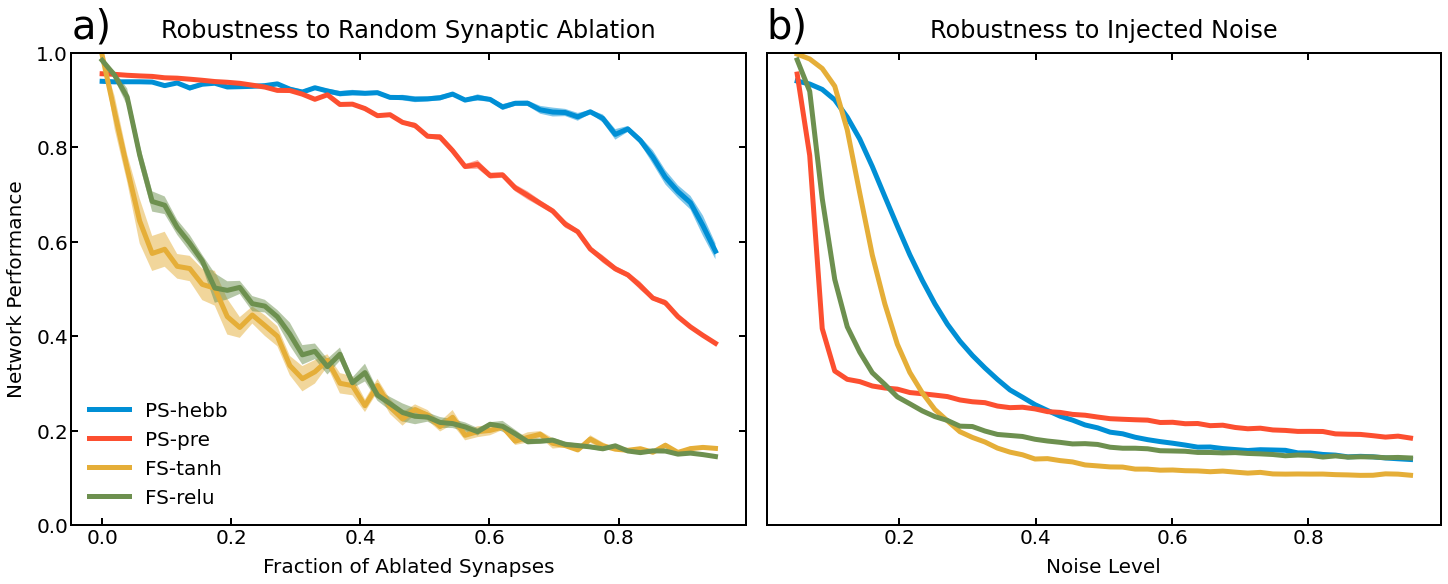

In [120]:
plt.style.use('sci_style.py')

fig, axs = plt.subplot_mosaic([['a)', 'b)']], figsize = (20,8),constrained_layout=True)
lw = 5
fs = 40

root_n = np.sqrt(num_repeats)



axs['a)'].plot(structural_noise_levels,accs_ah_repeated.mean(0),label = 'PS-hebb',linewidth=lw)
axs['a)'].fill_between(structural_noise_levels,accs_ah_repeated.mean(0) - accs_ah_repeated.std(0)/root_n, accs_ah_repeated.mean(0) + accs_ah_repeated.std(0)/root_n, alpha=0.5)

axs['a)'].plot(structural_noise_levels,accs_stsp_repeated.mean(0),label = 'PS-pre',linewidth=lw)
axs['a)'].fill_between(structural_noise_levels,accs_stsp_repeated.mean(0) + accs_stsp_repeated.std(0)/root_n, accs_stsp_repeated.mean(0) - accs_stsp_repeated.std(0)/root_n, alpha=0.5)

axs['a)'].plot(structural_noise_levels,accs_tanh_repeated.mean(0),label = 'FS-tanh',linewidth=lw)
axs['a)'].fill_between(structural_noise_levels,accs_tanh_repeated.mean(0) + accs_tanh_repeated.std(0)/root_n, accs_tanh_repeated.mean(0) - accs_tanh_repeated.std(0)/root_n, alpha=0.5)

axs['a)'].plot(structural_noise_levels,accs_relu_repeated.mean(0),label = 'FS-relu',linewidth=lw)
axs['a)'].fill_between(structural_noise_levels,accs_relu_repeated.mean(0) + accs_relu_repeated.std(0)/root_n, accs_relu_repeated.mean(0) - accs_relu_repeated.std(0)/root_n, alpha=0.5)
#axs['b)'].set_ylabel('Accuracy')

axs['a)'].set_xlabel('Fraction of Ablated Synapses')
axs['a)'].set_title('Robustness to Random Synaptic Ablation')
#axs['b)'].legend()
axs['a)'].set_ylim(0,1)
axs['a)'].set_title('a)', fontfamily='DejaVu Sans', loc='left', fontsize=fs)
axs['a)'].set_ylabel('Network Performance')
axs['a)'].legend()

axs['b)'].plot(input_noise_levels,accs_ah_input_repeated.mean(0),label = 'PS-hebb',linewidth=lw)
axs['b)'].fill_between(input_noise_levels,accs_ah_input_repeated.mean(0) - accs_ah_input_repeated.std(0)/root_n, accs_ah_input_repeated.mean(0) + accs_ah_input_repeated.std(0)/root_n, alpha=0.5)

axs['b)'].plot(input_noise_levels,accs_stsp_input_repeated.mean(0),label = 'PS-pre',linewidth=lw)
axs['b)'].fill_between(input_noise_levels,accs_stsp_input_repeated.mean(0) - accs_stsp_input_repeated.std(0)/root_n, accs_stsp_input_repeated.mean(0) + accs_stsp_input_repeated.std(0)/root_n, alpha=0.5)

axs['b)'].plot(input_noise_levels,accs_tanh_input_repeated.mean(0),label = 'FS-tanh',linewidth=lw)
axs['b)'].fill_between(input_noise_levels,accs_tanh_input_repeated.mean(0) - accs_tanh_input_repeated.std(0)/root_n, accs_tanh_input_repeated.mean(0) + accs_tanh_input_repeated.std(0)/root_n, alpha=0.5)

axs['b)'].plot(input_noise_levels,accs_relu_input_repeated.mean(0),label = 'FS-relu',linewidth=lw)
axs['b)'].fill_between(input_noise_levels,accs_relu_input_repeated.mean(0) - accs_relu_input_repeated.std(0)/root_n, accs_relu_input_repeated.mean(0) + accs_relu_input_repeated.std(0)/root_n, alpha=0.5)


axs['b)'].set_xlabel('Noise Level')
axs['b)'].set_title('Robustness to Injected Noise')

axs['b)'].set_ylim(0,1)
#axs['a)'].set_xlim(0,0.5)
axs['b)'].set_title('b)', fontfamily='DejaVu Sans', loc='left', fontsize=fs)
axs['b)'].set_yticks([])



#axs['b)'].set_xlim(0,0.5)
plt.savefig('Figs/robustness.png',dpi = 300)

array([0.0009407 , 0.00108598, 0.00112293, 0.00198383, 0.00153566,
       0.00344184, 0.00307854, 0.00381072, 0.00292062, 0.00338576,
       0.0042784 , 0.00524464, 0.00432466, 0.00445522, 0.00399367,
       0.00336405, 0.00297121, 0.00290864, 0.0042003 , 0.00463974,
       0.00278827, 0.00367424, 0.00335184, 0.00314938, 0.00313708,
       0.00412439, 0.00450818, 0.00339396, 0.0029726 , 0.00266289,
       0.00292083, 0.00176474, 0.00285847, 0.00287496, 0.00115301,
       0.00192381, 0.00420408, 0.00328305, 0.00237327, 0.00186149,
       0.00201822, 0.00424869, 0.00336212, 0.00288196, 0.0041319 ,
       0.00205572, 0.0042971 , 0.00243985, 0.00302716, 0.00336737])

In [41]:
model = dDMTSNet.load_from_checkpoint('/home/leo/ExpStableDynamics/DMTSANN/_lightning_sandbox/_lightning_sandbox/checkpoints/last.ckpt')

#model.rnn.process_noise = 0.05

inp, out_des,y,test_on,dis_bool = next(iter(tester))
out_readout, out_hidden,w_hidden,_= model(inp)
#acc_stsp = get_validation_accuracy(model,tester)
#acc_stsp

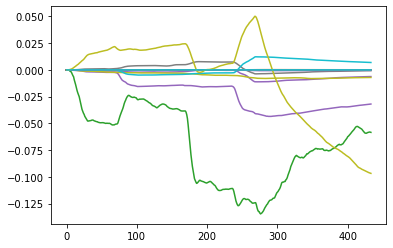

In [42]:
with torch.no_grad():
    plt.plot(w_hidden[2,:,:])

In [44]:
model.rnn.process_noise = 0.05
acc_stsp = get_validation_accuracy(model,tester)
acc_stsp

0.9907078598484849

0.9315814393939393